Dev notebook
============

In [1]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage as ndi
from scipy import signal
from scipy import stats
from scipy import optimize

import cv2

from domb.reg_type import wf_x2_m2 as wf
from domb.fret.e_fret.e_app import Eapp
from domb.red_green import wt_vs_mut_multistim
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

# WF x2 m2 uploading

/home/wisstock/bio/scripts/DoMB_tools/src/domb/utils/masking.py:56: RuntimeWarning: overflow encountered in exp
  exp = lambda x,a,b: a * np.exp(-b * x)
/home/wisstock/bio/scripts/DoMB_tools/src/domb/utils/masking.py:56: RuntimeWarning: overflow encountered in multiply
  exp = lambda x,a,b: a * np.exp(-b * x)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


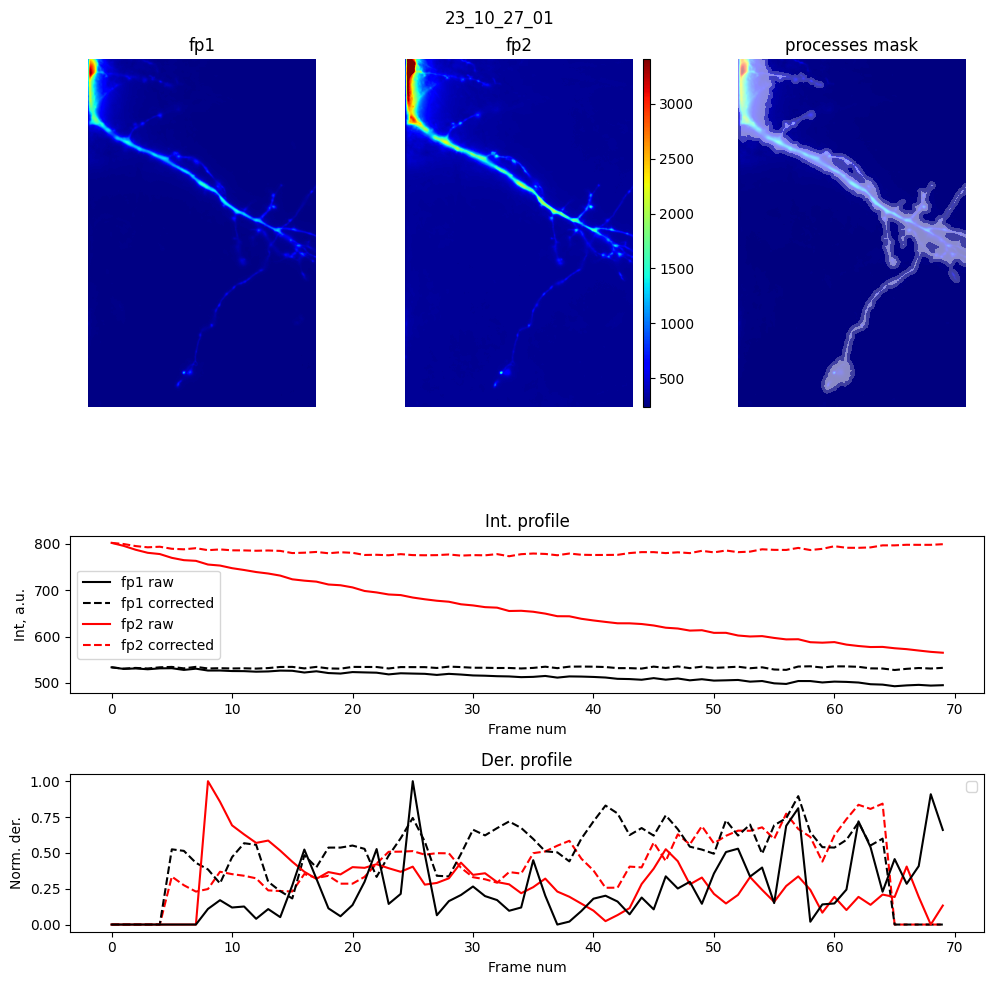

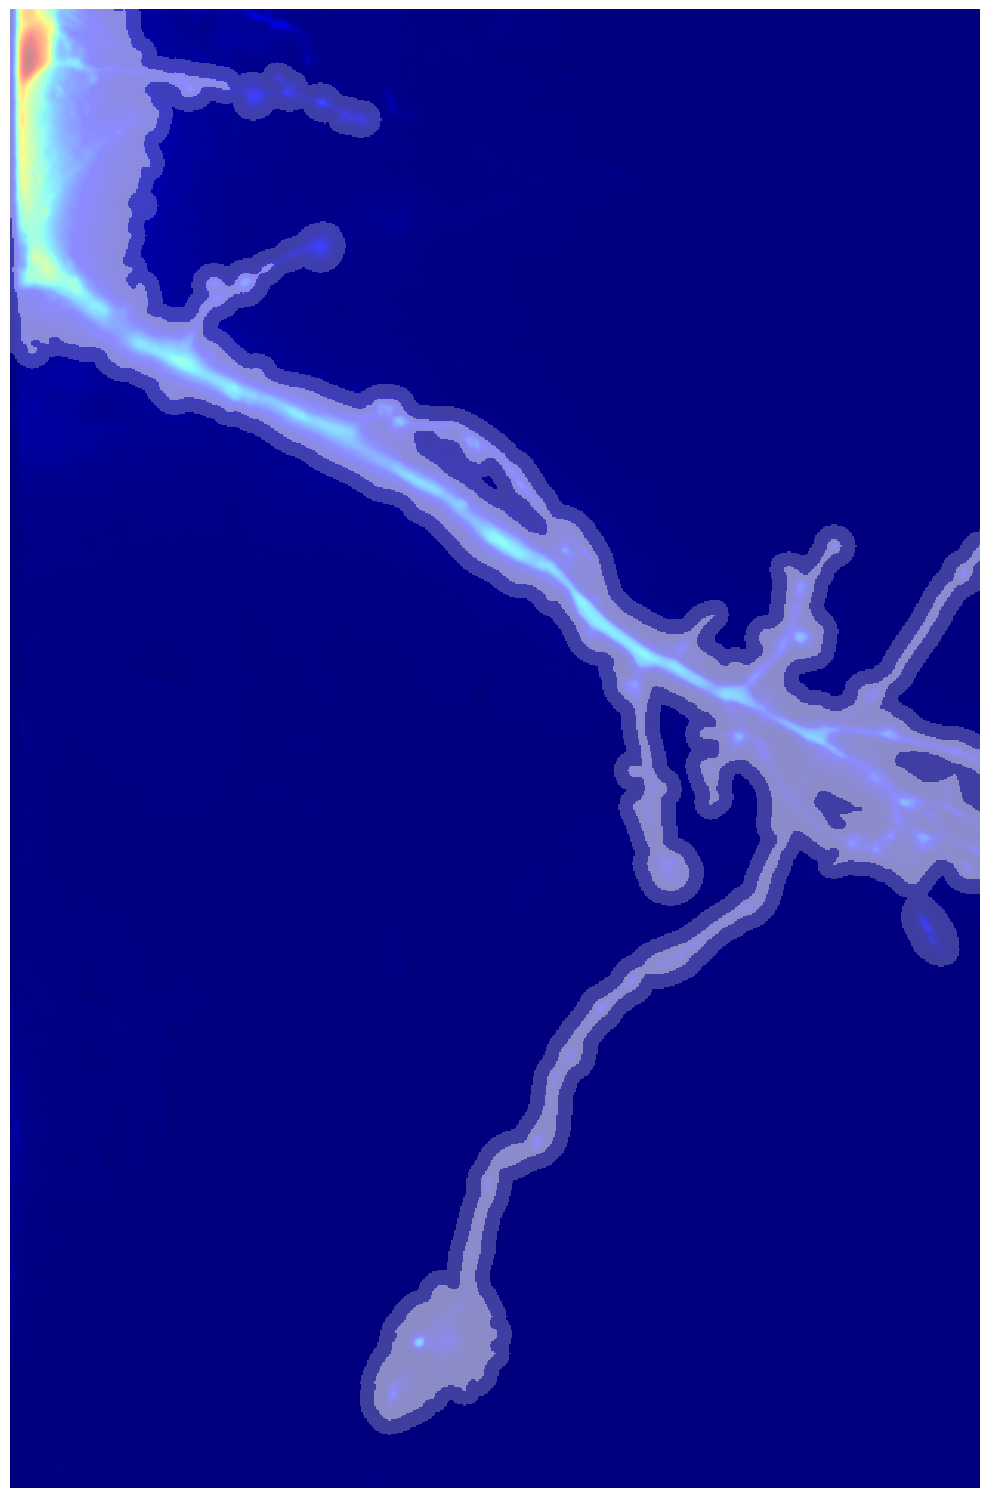

In [2]:
reg_path = 'data/wt_vs_mut/23_10_27_01.tif'
# reg_path = 'data/wt_vs_mut/23_06_23_11.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]

# fp1-CFP(1), fp2-YFP(3) or fp1-RFP(3), fp2-YFP(0)
reg = wf(img_path=reg_path, img_name=reg_name, ch_order={'fp1':3,'fp2':0}, gauss_sigma=.75, border_crop=20,  # regtype parameters
         proc_sigma=1.5, win_size=801, k_val=1e-5, r_val=0.5,    # processes masking parameters
         soma_mask=False, soma_th=.5, soma_ext=50,
         proc_ext=10,
         select_largest_mask=True)

reg.ch_pic()
reg.processes_mask_pic()

# Photobleaching correction with exponential fit

In [ ]:
def pb_exp_correction(input_img:np.ndarray, mask:np.ndarray):
    """ Image series photobleaching correction by exponential fit.
    
    Correction proceeds by masked area of interest, not the whole frame to prevent autofluorescence influence.

    Parameters
    ----------
    input_img: ndarray [t,x,y]
        input image series
    mask: ndarray [x,y]
        mask of region of interest, must be same size with image frames

    Returns
    -------
    corrected_img: ndarray [t,x,y]
        corrected image series
    r_val: float
        R-squared value of exponential fit

    """
    exp = lambda x,a,b: a * np.exp(-b * x)
    # bi_exp = lambda x,a,b,c,d: (a * np.exp(-b * x)) + (c * np.exp(-d * x))

    bleach_profile = np.mean(input_img, axis=(1,2), where=mask)
    x_profile = np.linspace(0, bleach_profile.shape[0], bleach_profile.shape[0])

    popt,_ = optimize.curve_fit(exp, x_profile, bleach_profile)
    bleach_fit = np.vectorize(exp)(x_profile, *popt)
    bleach_coefs =  bleach_fit / bleach_fit.max()
    bleach_coefs = bleach_coefs.reshape(-1, 1, 1)
    corrected_image = input_img/bleach_coefs

    _,_,r_val,_,_ = stats.linregress(bleach_profile, bleach_fit)

    return corrected_image, r_val


In [ ]:
int_curve = np.mean(reg.fp2_img_raw, axis=(1,2), where=reg.proc_mask)

print(int_curve.shape)

plt.figure(figsize=(12,5))
plt.plot(int_curve)
plt.show()

In [ ]:
corrected_img,_ = pb_exp_correction(input_img=reg.fp2_img_raw, mask=reg.proc_mask)
print(corrected_img)
corr_curve = np.mean(corrected_img, axis=(1,2), where=reg.proc_mask)

plt.figure(figsize=(12,5))
plt.plot(corr_curve)
plt.plot(int_curve, linestyle='--')
plt.show()

In [ ]:


exp = lambda x,a,b: a * np.exp(-b * x)
bi_exp = lambda x,a,b,c,d: (a * np.exp(-b * x)) + (c * np.exp(-d * x))

popt,_ = optimize.curve_fit(exp, x_line, int_curve)
print(popt)

bleach_fit = np.vectorize(exp)(x_line, *popt)

plt.figure(figsize=(12,5))
plt.plot(x_line, int_curve)
plt.plot(x_line, bleach_fit, linestyle='--')
plt.show()

In [ ]:
stats.linregress(int_curve, bleach_fit)

In [ ]:
bleach_coefs =  bleach_fit / bleach_fit.max()
bleach_coefs

In [ ]:
bleach_coefs = bleach_coefs.reshape(-1, 1, 1)
bleach_coefs.shape

In [ ]:
int_corr = np.mean(reg.fp2_img_raw/bleach_coefs, axis=(1,2), where=reg.proc_mask)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(x_line, int_curve)
plt.plot(x_line, int_corr, linestyle=':')
plt.plot(x_line, bleach_fit, linestyle='--')
plt.show()

In [ ]:
def arr_cascade_plot(input_arr:np.ndarray, y_shift:float=0.1,
                     min_amp:float=0):
    plt.figure(figsize=(20, 8))
    
    shift = 0
    for num_ROI in range(input_arr.shape[0]):
        prof_ROI = input_arr[num_ROI]
        if prof_ROI.max() < min_amp:
            continue
        else:
            plt.plot(prof_ROI+shift, alpha=.85, label=f'ROI {num_ROI}')
            shift += y_shift

    # for line_name in line_dict:
    #     line_lim = line_dict[line_name]
    #     plt.plot(line_lim, [-0.4] * len(line_lim), label=line_name, linewidth=4)

    # plt.vlines(x=[-20], ymin=[-0.1], ymax=[0.0], linewidth=3, color='k')
    # plt.text(x=-30, y=-0.2, s="0.1", size=15, rotation=90.)

    # plt.hlines(y=[-0.75], xmin=[-2], xmax=[8], linewidth=3, color='k')
    # plt.text(x=30, y=-1.15, s="10 s", size=15)

    plt.axis('off')
    # plt.legend(loc=2)
    plt.show()


arr_cascade_plot(fp1_df_prof, y_shift=0.5, min_amp=0.1)

# Channels registration

## Skimage

In [ ]:
from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
from skimage import transform
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

In [ ]:
ref_img = reg.fp1_img[3]
offset_img = reg.fp2_img[3]
mask = reg.proc_mask

shift, error, diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=500)
print(shift, error, diffphase)

fig, ax = plt.subplots(ncols=2, figsize=(15,15))
ax[0].imshow(ref_img)
ax[1].imshow(offset_img)
ax[0].axis('off')
ax[1].axis('off')

#### Optical flow

In [ ]:
def flow_restoration(raw_ref_img, raw_offset_img):
    ref_img = filters.sobel_h(raw_ref_img)
    offset_img = filters.sobel_h(raw_offset_img)
    input_shift, input_error, input_diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
    v, u = optical_flow_tvl1(ref_img, offset_img)
    nr, nc = ref_img.shape
    r_coord, c_coord = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    flow_warp_matrix = np.array([r_coord + v, c_coord + u])
    flow_warp_img = transform.warp(raw_offset_img, flow_warp_matrix, mode='edge', order=5)
    output_shift, output_error, output_diffphase = phase_cross_correlation(raw_ref_img, flow_warp_img, upsample_factor=1000)
    print(f'Flow restoration: input shift={input_shift}, outputshift={output_shift}')
    return flow_warp_img

flow_warp_img = flow_restoration(ref_img, offset_img)

#### Phase corr

In [ ]:
def phase_restoration(raw_ref_img, raw_offset_img):
    ref_img = filters.sobel_h(raw_ref_img)
    offset_img = filters.sobel_h(raw_offset_img)
    input_shift, input_error, input_diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
    tform = transform.SimilarityTransform(translation=(-input_shift[1], -input_shift[0]))
    phase_warp_img = transform.warp(raw_offset_img, tform, order=5)
    output_shift, output_error, output_diffphase = phase_cross_correlation(raw_ref_img, phase_warp_img, upsample_factor=1000)
    print(f'Phase restoration: input shift={input_shift}, outputshift={output_shift}')
    return phase_warp_img

phase_warp_img = phase_restoration(ref_img, offset_img)

## OpenCV

In [ ]:
def Gradient(Image) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = filters.sobel_h(Image)
    grad_y = filters.sobel_v(Image)
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad.astype('float32')

Image1 = ref_img
Image2 = offset_img
algn_scale = 0.5
    
Temp1 = cv2.resize(Image1, dsize=(0, 0),
                    fx=algn_scale, fy=algn_scale,
                    interpolation = cv2.INTER_LANCZOS4)
Temp2 = cv2.resize(Image2, dsize=(0, 0), 
                    fx=algn_scale, fy=algn_scale,
                    interpolation = cv2.INTER_LANCZOS4)


print(Image1.shape)
print(Temp1.shape)

warp_mode = cv2.MOTION_AFFINE
WarpMatrix = np.eye(2, 3, dtype='float32')
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
(cc, WarpMatrix) = cv2.findTransformECC(Gradient(Temp1), Gradient(Temp2), WarpMatrix, warp_mode, criteria)
WarpMatrix[:, 2] = WarpMatrix[:, 2] / algn_scale

print(WarpMatrix)


In [ ]:
def cv_warp(Image2, WarpMatrix):
    warp_img = cv2.warpAffine(Image2, WarpMatrix, Image2.shape[::-1], flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP)
    return warp_img
# warp_img_cv2 = transform.warp(offset_img, WarpMatrix, order=5)

ecc_warp_img = cv_warp(offset_img, WarpMatrix)

shift, error, diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
print(shift, error, diffphase)

shift, error, diffphase = phase_cross_correlation(ref_img, ecc_warp_img, upsample_factor=1000)
print(shift, error, diffphase)

## Algn comparison with flow

In [ ]:
def misalign_estimate(img1, img2):
    v, u = optical_flow_tvl1(img1, img2)
    norm = np.sqrt(u ** 2 + v ** 2)

    nvec = 20  # Number of vectors to be displayed along each image dimension
    nl, nc = ref_img.shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    print(phase_cross_correlation(img1, img2, upsample_factor=1000))

    plt.figure(figsize=(8, 8))
    plt.imshow(norm)
    plt.quiver(x, y, u_, v_, color='r', units='dots',
            angles='xy', scale_units='xy', lw=3)
    plt.show()

In [ ]:
misalign_estimate(ref_img, offset_img)

misalign_estimate(ref_img, flow_warp_img)

misalign_estimate(ref_img, phase_warp_img)

# misalign_estimate(ref_img, ecc_warp_img)

# FRET

In [ ]:
ch0_crop = np.array([reg.ch0_img[0], reg.ch0_img[-1]])
ch1_crop = np.array([reg.ch1_img[0], reg.ch1_img[-1]])
ch2_crop = np.array([reg.ch2_img[0], reg.ch2_img[-1]])
ch3_crop = np.array([reg.ch3_img[0], reg.ch3_img[-1]])

In [ ]:
a=0.1489
b=0.1324
c=0.2481
d=0.8525
abcd = [a, b, c, d]

G = 6.117

reg_FRET = Eapp(dd_img=ch0_crop,
                da_img=ch1_crop,
                ad_img=ch2_crop,
                aa_img=ch3_crop,
                abcd_list=abcd, G_val=G,
                mask=reg.narrow_proc_mask, corr_by_mask=True)  # parameters for E_corr_calc

warp_FRET = Eapp(dd_img=ch0_crop,
                 da_img=ch1_crop,
                 ad_img=np.asarray([phase_restoration(raw_ref_img=ref_img, raw_offset_img=img) for img in ch2_crop]),
                 aa_img=np.asarray([phase_restoration(raw_ref_img=ref_img, raw_offset_img=img) for img in ch3_crop]),
                 abcd_list=abcd, G_val=G,
                 mask=reg.narrow_proc_mask, corr_by_mask=True)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))
ax[0].imshow(reg_FRET.Ecorr_img[-1], cmap='jet')
ax[1].imshow(warp_FRET.Ecorr_img[-1], cmap='jet')
ax[0].axis('off')
ax[1].axis('off')